## Exercise 1

Posterior mean: -0.4800887 
Posterior variance: 9.782615 


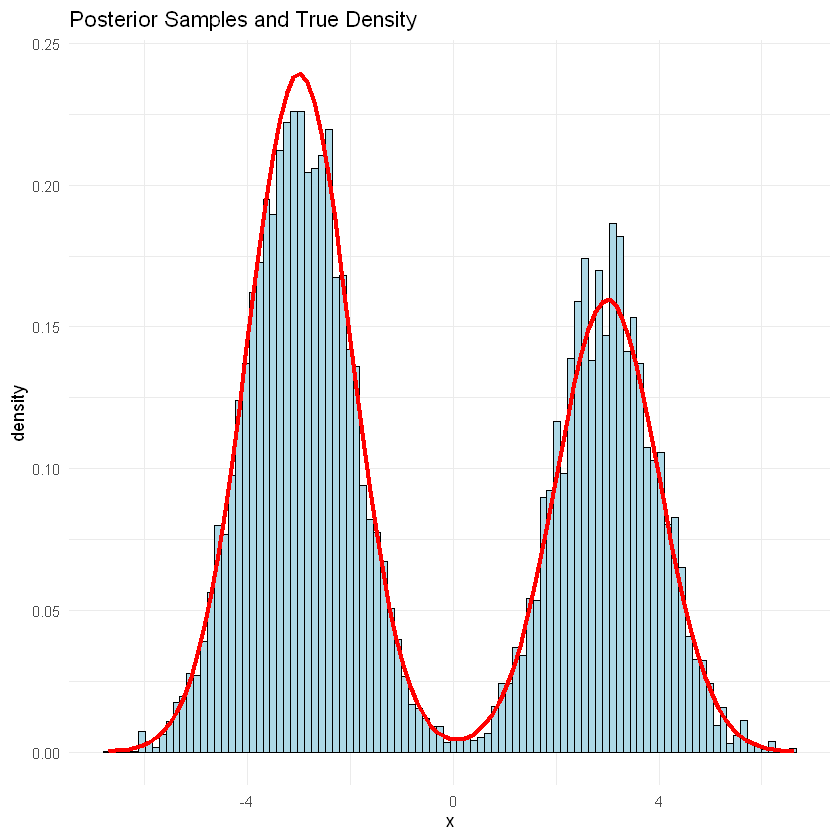

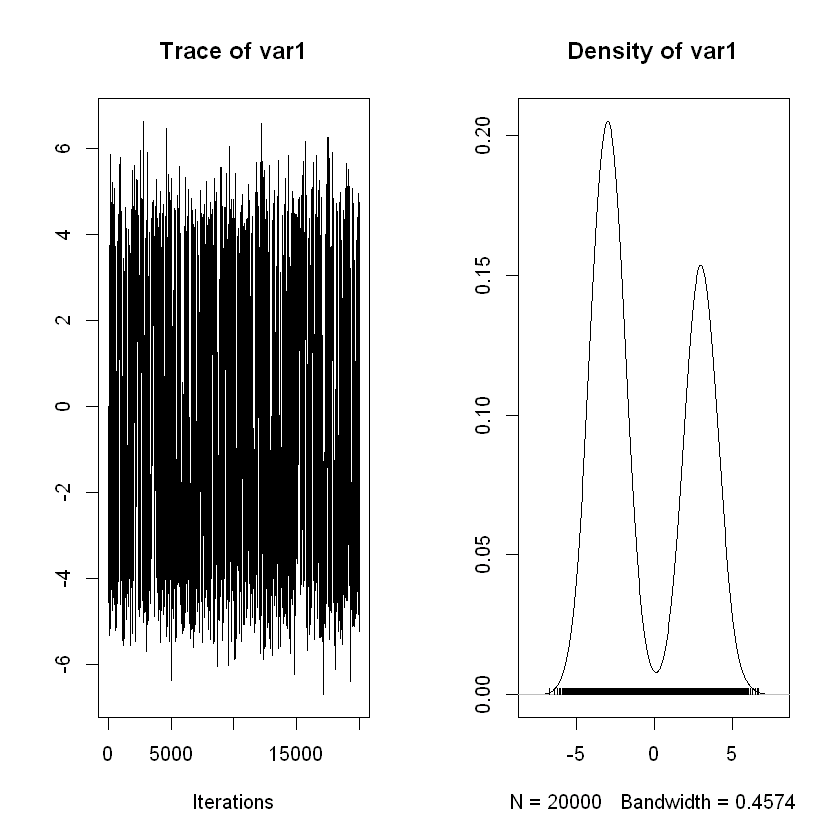

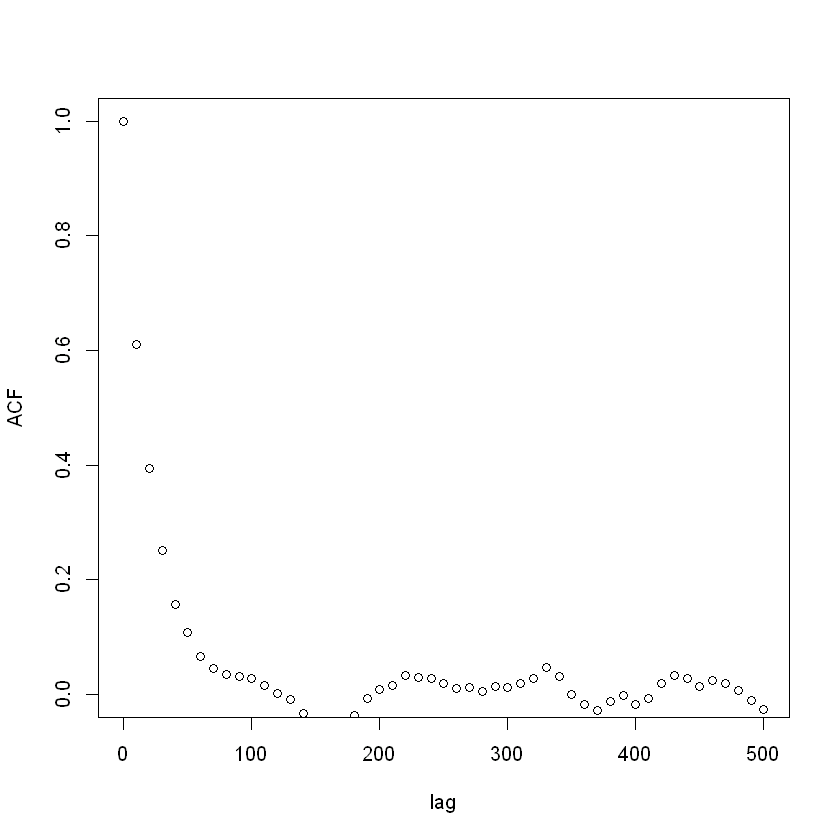

In [18]:
# Load libraries
library(coda)
library(ggplot2)

# Define the unnormalized target density g(x)
g <- function(x) {
  0.6 * dnorm(x, mean = -3, sd = 1) + 0.4 * dnorm(x, mean = 3, sd = 1)
}

# Metropolis-Hastings sampler
metropolis <- function(n_iter = 10000, proposal_sd = 2, init = 0) {
  samples <- numeric(n_iter)
  samples[1] <- init
  for (i in 2:n_iter) {
    proposal <- rnorm(1, mean = samples[i - 1], sd = proposal_sd)
    accept_ratio <- g(proposal) / g(samples[i - 1])
    if (runif(1) < accept_ratio) {
      samples[i] <- proposal
    } else {
      samples[i] <- samples[i - 1]
    }
  }
  return(samples)
}

# Generate samples
set.seed(1234)
samples <- metropolis(n_iter = 20000)

# Plot histogram of the posterior samples
df <- data.frame(x = samples)
ggplot(df, aes(x)) +
  geom_histogram(aes(y = ..density..), bins = 100, fill = "lightblue", color = "black") +
  stat_function(fun = g, color = "red", size = 1.2) +
  ggtitle("Posterior Samples and True Density") +
  theme_minimal()

# Compute mean and variance
posterior_mean <- mean(samples)
posterior_var <- var(samples)
cat("Posterior mean:", posterior_mean, "\n")
cat("Posterior variance:", posterior_var, "\n")

# CODA analysis
mcmc_samples <- mcmc(samples)
plot(mcmc_samples)                      # Trace and density plots
my.lags = seq(0,500,10)
y1 <- autocorr(mcmc_samples, lags = my.lags)
plot(my.lags, y1, ylim=c(0,1), xlab='lag', ylab='ACF')


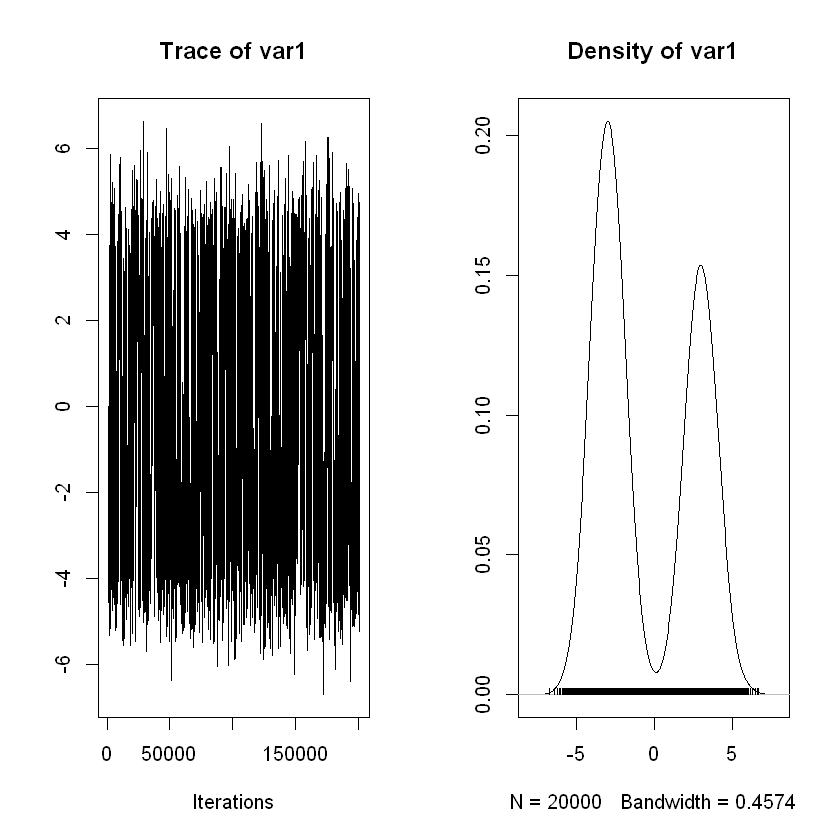

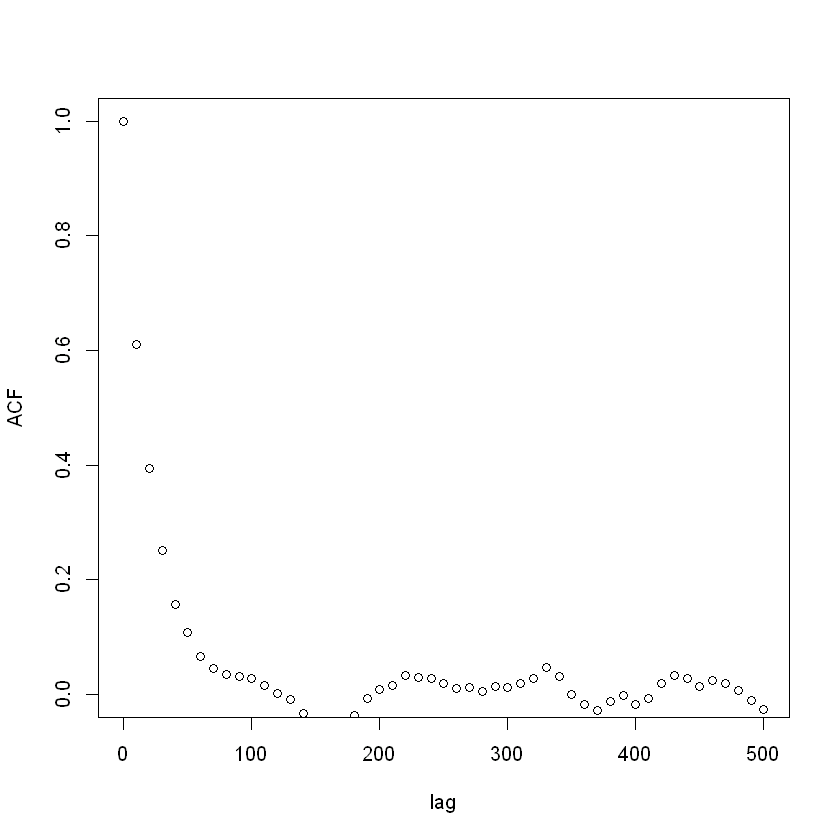

In [15]:
# Try burn-in and thinning
burnin <- 1000
thinning <- 10
thinned_samples <- mcmc(samples,start = burnin, thin = thinning)

# Plot thinned samples
plot(thinned_samples)

my.lags = seq(0,500,10)
y2 <- autocorr(thinned_samples, lags = my.lags)
plot(my.lags, y2, ylim=c(0,1), xlab='lag', ylab='ACF')

## Exercise 2

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 8
   Unobserved stochastic nodes: 2
   Total graph size: 20

Initializing model




Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean     SD Naive SE Time-series SE
m        11.075 0.8108  0.01147        0.01530
m_over_s  5.520 1.6015  0.02265        0.03596
s2        5.267 3.8562  0.05453        0.11254

2. Quantiles for each variable:

          2.5%    25%    50%    75%  97.5%
m        9.364 10.598 11.089 11.553 12.728
m_over_s 2.717  4.374  5.399  6.553  8.943
s2       1.581  2.888  4.182  6.390 15.433


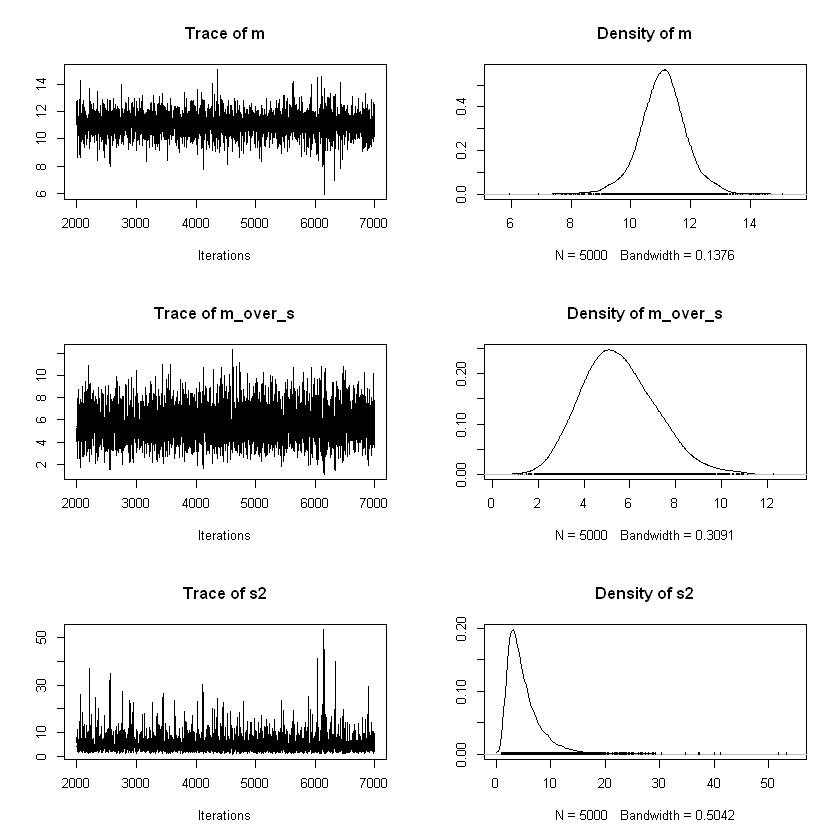

In [16]:
library(rjags)

model_string <- "
model {
  for (i in 1:length(x)) {
    x[i] ~ dnorm(m, 1.0/s2)
  }
  m ~ dunif(-10,30)
  s2 <- pow(s, 2)
  s ~ dunif(0, 100)

  m_over_s <- m / s
}
"
data <- NULL

data$x <- c(13.427, 8.588, 10.908, 11.582, 11.011, 9.735, 13.779, 9.763)


params <- c("m", "s2", "m_over_s")

model <- jags.model(textConnection(model_string), data = data)
update(model, 1000)  # Burn-in
samples <- coda.samples(model, variable.names = params, n.iter = 5000)

summary(samples)
plot(samples)


[1] "m"        "m_over_s" "s2"

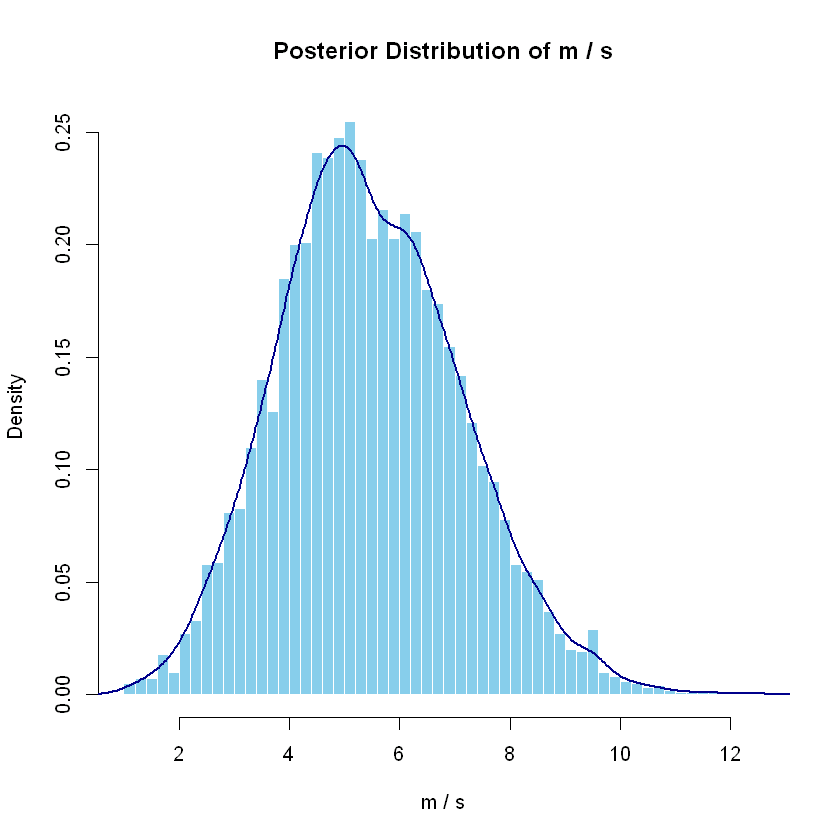

In [12]:
samples_matrix <- as.matrix(samples)
colnames(samples_matrix)

# Extract samples of m / s (named "m_over_s")
m_over_s_samples <- samples_matrix[, "m_over_s"]

# Plot the posterior distribution
hist(m_over_s_samples,
     breaks = 50,
     col = "skyblue",
     border = "white",
     main = "Posterior Distribution of m / s",
     xlab = "m / s",
     probability = TRUE)

lines(density(m_over_s_samples), col = "darkblue", lwd = 2)


## Exercise 3

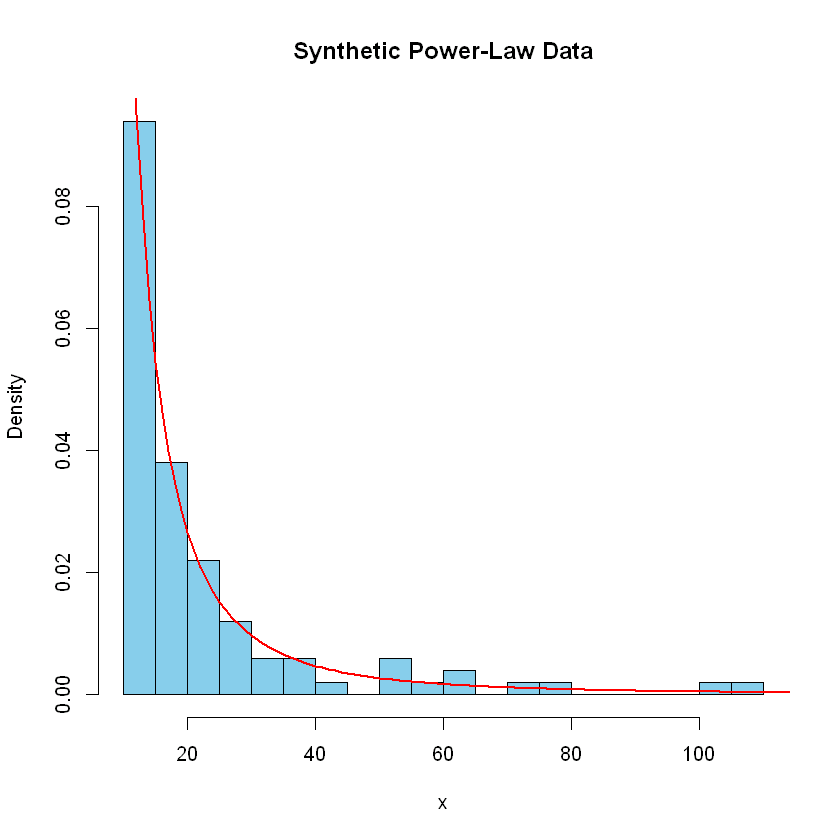

In [32]:
pld <- function(x, a, xm) {(a - 1) / xm * (x / xm)^(-a)}

xm <- 10
a <- 2.5
N <- 100

#sample with inverse cdf
u <- runif(n)
x <- xm * (1 - u)^(1 / (1 - a))

hist(x, breaks = 30,
     col = "skyblue",
     main = "Synthetic Power-Law Data",
     xlab = "x",
     probability = TRUE)
lines(0:350, sapply(0:350, function(x) pld(x, a, xm)),col = 'red', lwd = 2)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 1
   Total graph size: 811

Initializing model




Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      2.623145       0.159791       0.002260       0.002778 

2. Quantiles for each variable:

 2.5%   25%   50%   75% 97.5% 
2.330 2.514 2.617 2.729 2.955 


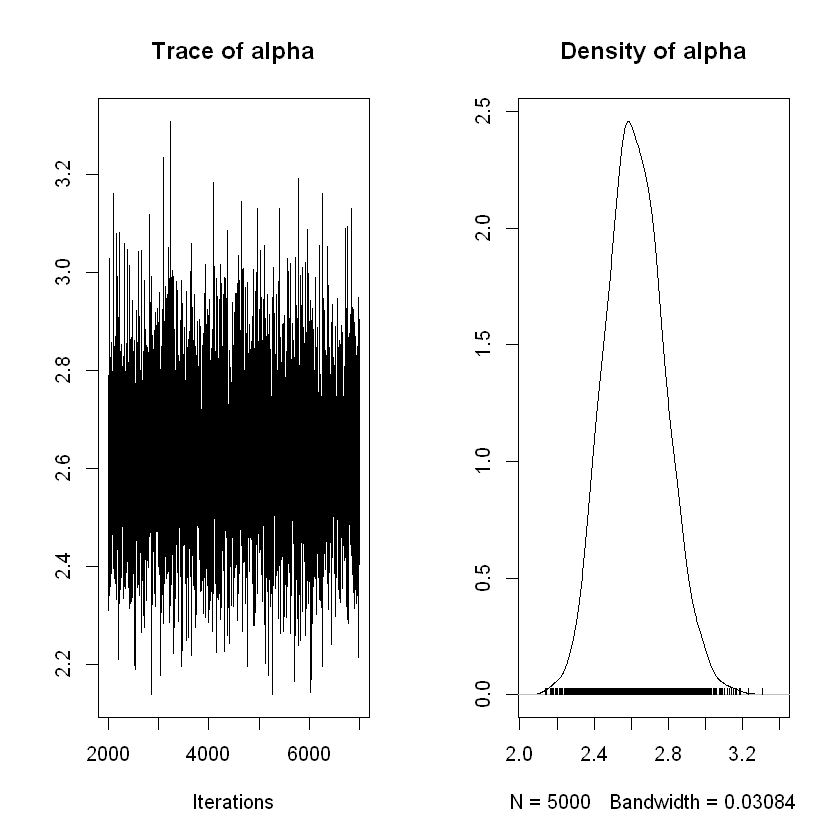

In [33]:
#zeros trick
model_string <- "
model {
    for(i in 1:N) {
    loglike[i] <- log(alpha - 1) - log(xm) - alpha * log(x[i]/xm)
    
    zeros[i] ~ dpois(phi[i])
    phi[i] <- -loglike[i] + c
    }

    alpha ~ dunif(1.01, 10)  
}
"

data <- NULL
data$x <- x
data$xm <- xm
data$N <- n
data$zeros <- rep(0, N)
data$c <- 100

params <- c("alpha")

model <- jags.model(textConnection(model_string), data = data)
update(model, 1000)  # Burn-in
samples <- coda.samples(model, variable.names = params, n.iter = 5000)

summary(samples)
plot(samples)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 1
   Total graph size: 811

Initializing model




Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      2.534225       0.084440       0.001194       0.001483 

2. Quantiles for each variable:

 2.5%   25%   50%   75% 97.5% 
2.373 2.476 2.535 2.593 2.701 


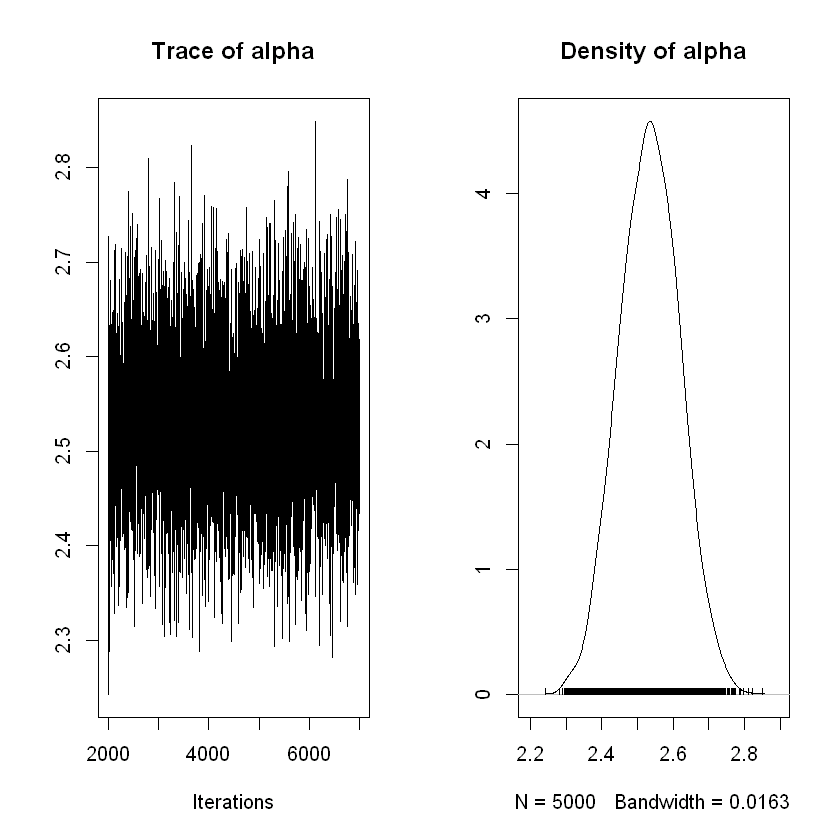

In [34]:
#zeros trick
model_string <- "
model {
    for(i in 1:N) {
    loglike[i] <- log(alpha - 1) - log(xm) - alpha * log(x[i]/xm)
    
    zeros[i] ~ dpois(phi[i])
    phi[i] <- -loglike[i] + c
    }

    alpha ~ dnorm(2.5, 100)  
}
"

data <- NULL
data$x <- x
data$xm <- xm
data$N <- n
data$zeros <- rep(0, N)
data$c <- 100

params <- c("alpha")

model <- jags.model(textConnection(model_string), data = data)
update(model, 1000)  # Burn-in
samples <- coda.samples(model, variable.names = params, n.iter = 5000)

summary(samples)
plot(samples)


In [36]:
# frequentist estimate with MLE

alpha_freq <- 1 + n / sum(log(x / xm))
cat("Frequentist estimator: ", alpha_freq)

Frequentist estimator:  2.605394